**SEND AI CASE STUDY**

Your team monitors social media to identify customer-experience issues in real-time. You have access to approximately 14k tweets directed at U.S. airlines, each labelled positive, neutral, or negative. Your goal is to build a simple, CPU-friendly NLP pipeline that transforms tweet texts into embeddings using GloVe vectors and trains a lightweight model to classify the sentiment of new tweets.

# Libraries

In [ ]:
!pip install demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import json
import os
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import demoji

from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-37-6894892c40d6>:27: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DOWNSAMPLE = False
CURRENT_DIR = "/content/drive/MyDrive/Send AI"
UNKNOWN_VECTOR = np.array([ 0.05209883, -0.09711445, -0.1380765 ,  0.11075345, -0.02722748, -0.00326409,  0.03176443, -0.05076874,  0.15321693, -0.02367382, -0.0078552 ,  0.08436131, -0.08042031, -0.08836847, -0.01713637,  0.07352565, -0.16472325,  0.05473585,  0.15367231, -0.05284015, -0.16474274, -0.00894895, -0.13604094, -0.03889371, -0.09204532,  0.02874651,  0.02445944,  0.19419461, -0.03297978,  0.00509352,  0.0146906 , -0.1554301 ,  0.03542742, -0.02936257,  0.01372886, -0.0606757 ,  0.02025392, -0.14560148,  0.05823914,  0.01729455,  0.16282158,  0.18634756, -0.06337869,  0.1306742 , -0.11122588,  0.0272168 ,  0.03868013,  0.15675613,  0.01344932,  0.1942456 , -0.01218801,  0.03659216, -0.08235365, -0.24420363,  0.07523726,  0.46423653,  0.06318451,  0.0508127 , -0.38147202, -0.20739552,  0.03489431, -0.18234783,  0.09021272, -0.02504168, -0.22256528,  0.03382994, -0.13379364, -0.14375682, -0.11264054, -0.03744001,  0.06188852,  0.09650661,  0.08384212,  0.1964642 , -0.07446123,  0.00921882,  0.03034359, -0.02482695,  0.27563572,  0.02422197, -0.23416583, -0.0523523 ,  0.10200828, -0.03673672,  0.2940292 ,  0.05685116,  0.01759575,  0.07998175, -0.07554322,  0.14788596,  0.01690632,  0.07576851,  0.07596124, -0.10800065,  0.20829839, -0.07841395,  0.08663727,  0.12381283, -0.23434106, -0.00925518])
# UNKNOWN_VECTOR = np.array([0]*100)

## Utils

In [ ]:
# taken from https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
# replaces emojis with a blank space
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess_tweet(text):
    # text = demoji.replace_with_desc(text, sep=" ") # replaces emojis with their textual description
    text = re.sub(r"http[s]?\://\S+", "", text) # removes urls
    text = deEmojify(text)  # remove emojis
    text = re.sub(r"@\S+", '', text) # remove mentions
    text = re.sub(r'\s+', ' ', text).strip() # remove extra spaces
    # text = re.sub(r"#\S+", "",text) # remove hashtags
    text = text.lower()  # convert to lowercase
    return text

def get_sentence_embedding(text, glove_model):
    text = preprocess_tweet(text)
    tokens = word_tokenize(text) # split the sentence into words / tokens
    tokens = [word for word in tokens if word.isalpha()]  # remove non-alphabetic tokens
    embeddings = []
    for token in tokens:
        try:
            embeddings.append(glove_model[token])
        except:
            embeddings.append(UNKNOWN_VECTOR)

    if not embeddings:
        return UNKNOWN_VECTOR

    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    return np.mean(embeddings, axis=0).astype(np.float64)


# https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
# loads the glove dictionary, and then we can query the model like this
# glove_model(['dog']) which will give the embedding of the word dog
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model


# code to print the confusion matrix
def get_confusion_matrix(y_test, y_pred, model_name, label_encoder, downsample):
  cf_matrix = confusion_matrix(y_test, y_pred)
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

  row_percentages_values = []
  for row in cf_matrix:
      row_sum = np.sum(row)
      if row_sum == 0:
          row_percentages_values.extend([0] * len(row)) # Append 0 for percentage values
      else:
          row_percentages_values.extend([value / row_sum for value in row])

  # Create a normalized confusion matrix for the heatmap data
  cf_matrix_normalized = np.asarray(row_percentages_values).reshape(cf_matrix.shape)

  # Create percentage strings for annotation
  group_percentages_strings = ["{0:.2%}".format(value) for value in row_percentages_values]

  # Create labels for each cell combining count and percentage
  labels_list = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages_strings)]

  # Reshape the labels list into a 3x3 numpy array to match the cf_matrix shape
  labels = np.asarray(labels_list).reshape(cf_matrix.shape)

  # Get the class names from the label_encoder to use as axis labels
  class_names = label_encoder.classes_

  # Plot the heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(cf_matrix_normalized, annot=labels, fmt="", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix (Row Normalized Percentages)")
  plt.show()


# Loading Data

In [ ]:
glove_model = load_glove_model(f"{CURRENT_DIR}/data/glove.6B.100d.txt")

Loading Glove Model
400000 words loaded!


Contains two jsonl files, where each line contains a tweet and its sentiment (positive / neutral / negative).

In [ ]:
train_texts = []
train_labels = []
test_texts = []
test_labels = []

with open(f"{CURRENT_DIR}/data/tweet_sentiment.train.jsonl", 'r', encoding='utf-8') as file:
    for line in file:
        data = json.loads(line)
        train_texts.append(data['text'])
        train_labels.append(data['label'])

with open(f"{CURRENT_DIR}/data/tweet_sentiment.test.jsonl", 'r', encoding='utf-8') as file:
    for line in file:
        data = json.loads(line)
        test_texts.append(data['text'])
        test_labels.append(data['label'])

train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

In order to get the embeddings, we apply the following steps

* Convert emojis into their textual form (I love this movie 🔥 -> I love this movie fire) (OPTIONAL)
* Remove URLs
* Remove emojis
* Remove mentions
* Convert to lowercase
* Then tokenize and remove non alphabetical words
* Then get the word embedding
* Aggregate them together, and you have a tweet embedding

In [ ]:
# get the sentence embeddings for the train and test sets
train_df['embedding'] = train_df['text'].apply(lambda x: get_sentence_embedding(x, glove_model))
test_df['embedding'] = test_df['text'].apply(lambda x: get_sentence_embedding(x, glove_model))

In [ ]:
# your choice, whether to DOWNSAMPLE the training set or not
if DOWNSAMPLE:
  train_df = train_df.groupby('label', group_keys=False).sample(n=1890, random_state=42) # we choose 1890 because the positive label has the lowest count = 1890 in the train set

# Data Exploration

This is the class distribution for the train set. Right off the bat, we see that there are a lot of negative samples as compared to the other two classes. This might potentially skew the model results.

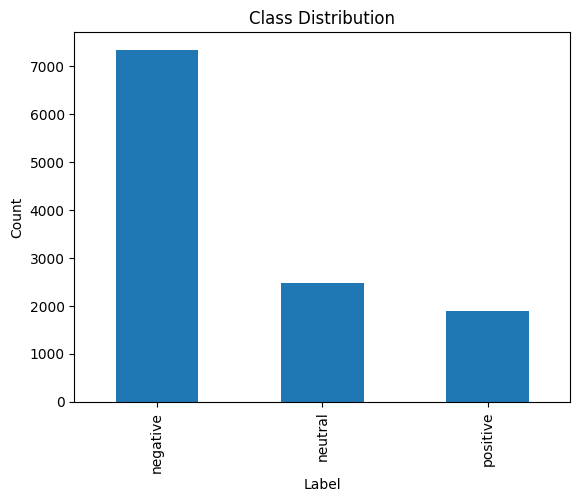

In [ ]:
# plotting the class distribution
train_df['label'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

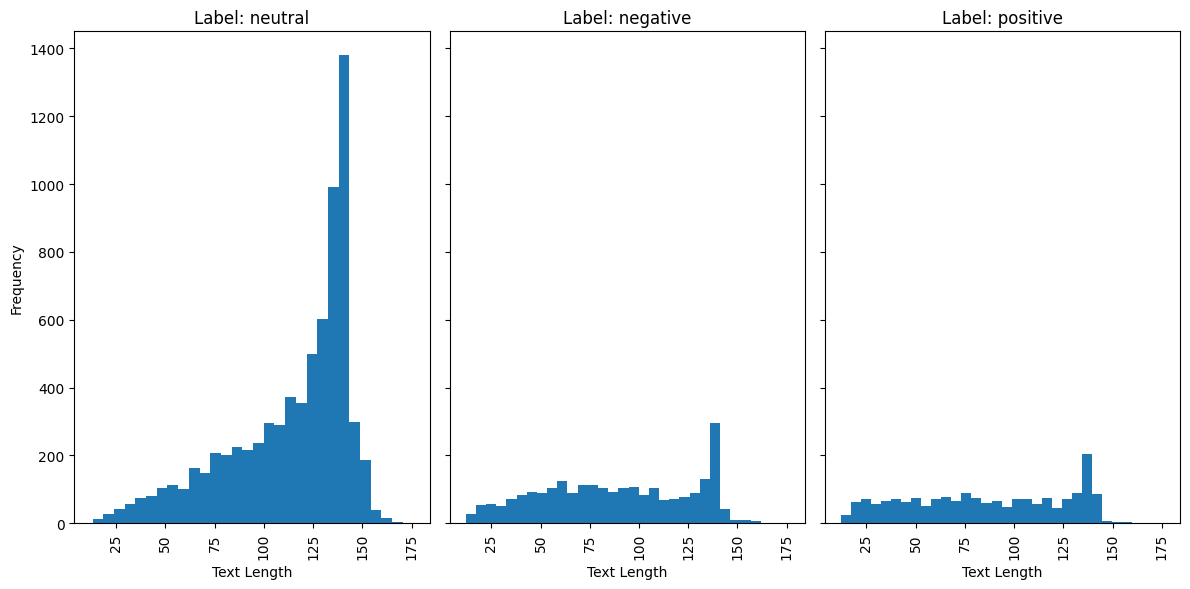

In [ ]:
# hisotgram of length of tweets per sentiment
train_df['text_len'] = train_df['text'].str.len()
axes = train_df['text_len'].hist(by=train_df['label'], bins=30, figsize=(12, 6), layout=(1, 3), sharex=True, sharey=True)

for ax, label in zip(axes.flatten(), train_df['label'].unique()):
    ax.set_title(f'Label: {label}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Then I visualize the embedding space. I apply UMAP on the train and test set embeddings, reducing them from 100D to 2D, for better visualization.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


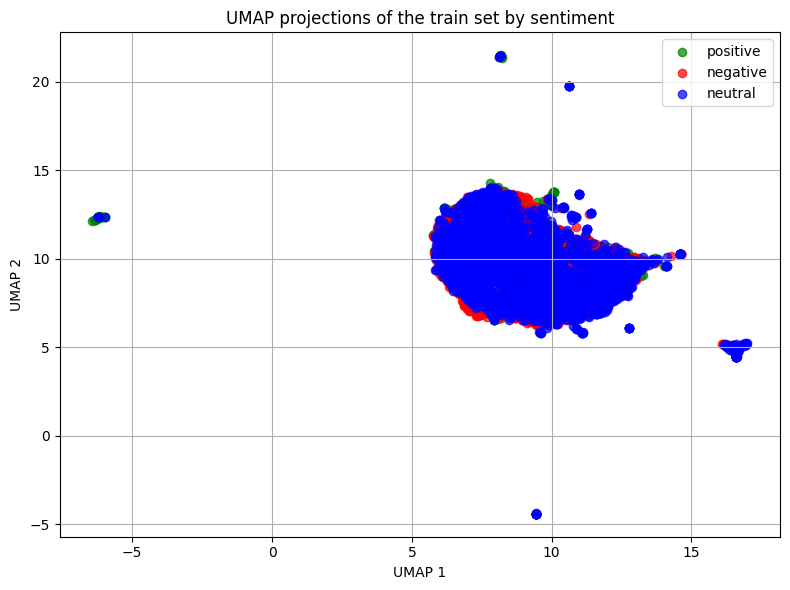

In [ ]:
all_embeddings = np.vstack(train_df['embedding'].values)
all_labels = train_df['label'].values

label_to_color = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'blue'
}
point_colors = [label_to_color[label] for label in all_labels]

label_to_marker = {
    'positive': 'o',
    'negative': 's',
    'neutral': '^'
}

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
for sentiment in label_to_color:
    idx = train_df['label'] == sentiment
    plt.scatter(
        umap_embeddings[idx, 0], umap_embeddings[idx, 1],
        c=label_to_color[sentiment],
        label=sentiment,
        alpha=0.7
    )

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP projections of the train set by sentiment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


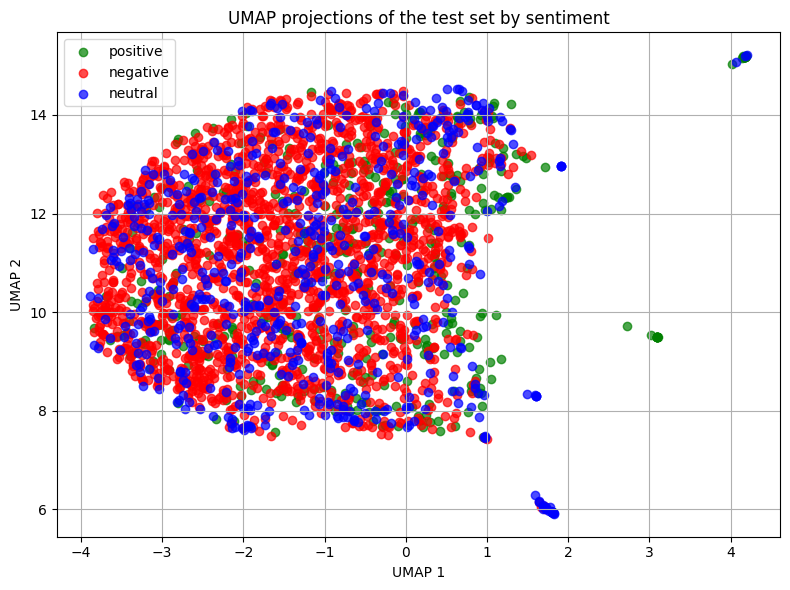

In [ ]:
all_embeddings = np.vstack(test_df['embedding'].values)
all_labels = test_df['label'].values

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
for sentiment in label_to_color:
    idx = test_df['label'] == sentiment
    plt.scatter(
        umap_embeddings[idx, 0], umap_embeddings[idx, 1],
        c=label_to_color[sentiment],
        label=sentiment,
        alpha=0.7
    )

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP projections of the test set by sentiment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The UMAP plots reveal significant overlap between the embeddings of all three sentiment classes (positive, negative, and neutral). This lack of clear separation in the embedding space suggests that:
1. The task is chalenging due to overlapping semantic features across sentiment categories
2. The model will need to rely on subtle linguistic patterns
3. High performance may require sophisticated feature extraction or architecture design

# Preliminary Models

Before I get into the experiments, there are 3 design choices I make (not sure if it is the right word).
1. Downsampling : Since there are way more negative samples, I downsample for all classes to have equal number of training samples, and this number is equal to the smallest class in the dataset (in this case the positive class).
2. Handling OOV words : Zero vector, or we aggregate the embeddings of all tokens in the vocabulary (as per https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt/53717345#53717345).
3. Emojis to text : One thing that is common in tweets is the way people write, very informally and using emojis. Especially in the task of sentiment classification, I believe that these emojis aid the model in the task. So, I convert these emojis into their textual description. For example, "This movie is 🔥" -> "This movie is fire"



In [ ]:
X_train = np.vstack(train_df['embedding'].values)
X_test = np.vstack(test_df['embedding'].values)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])
models = []
results = []

## Logistic Regression

Logistic Regression : 
              precision    recall  f1-score   support

    negative       0.77      0.91      0.84      1835
     neutral       0.57      0.39      0.46       620
    positive       0.74      0.53      0.62       473

    accuracy                           0.74      2928
   macro avg       0.69      0.61      0.64      2928
weighted avg       0.72      0.74      0.72      2928





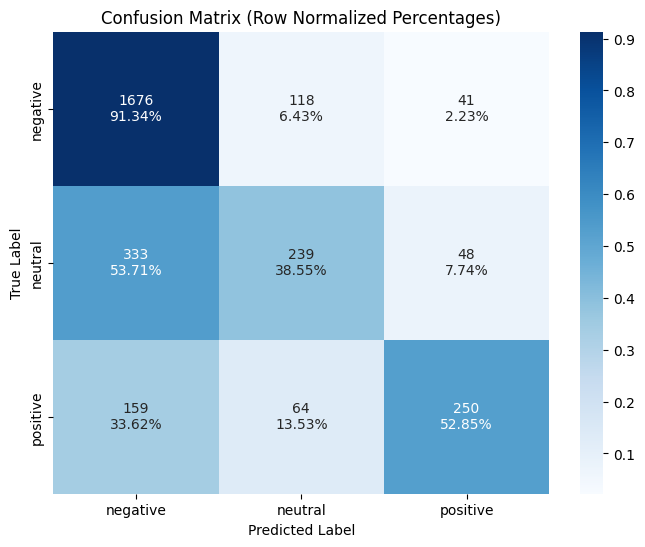

In [ ]:
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Logistic Regression : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}\n\n")
temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
models.append('Logistic Regression')
get_confusion_matrix(y_test, y_pred, "logistic_regression", label_encoder, DOWNSAMPLE)

## SVM

KERNEL : linear
              precision    recall  f1-score   support

    negative       0.86      0.70      0.78      1835
     neutral       0.44      0.62      0.52       620
    positive       0.60      0.70      0.65       473

    accuracy                           0.69      2928
   macro avg       0.63      0.68      0.65      2928
weighted avg       0.73      0.69      0.70      2928





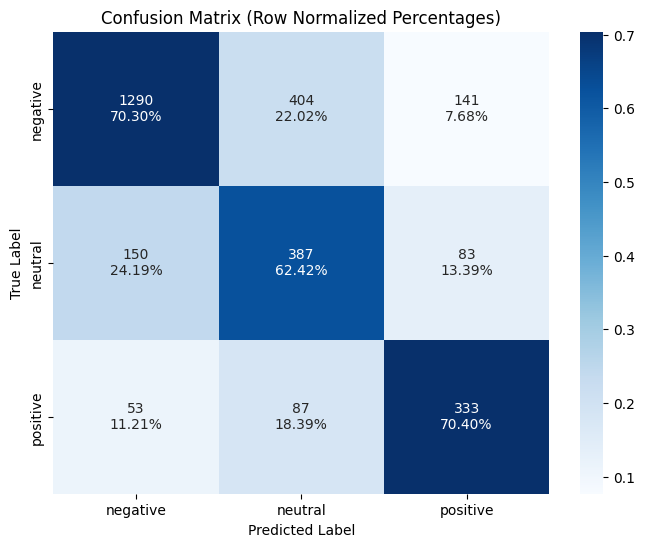

****************************************************************************************************
KERNEL : poly
              precision    recall  f1-score   support

    negative       0.87      0.72      0.79      1835
     neutral       0.48      0.66      0.55       620
    positive       0.60      0.73      0.66       473

    accuracy                           0.71      2928
   macro avg       0.65      0.70      0.67      2928
weighted avg       0.75      0.71      0.72      2928





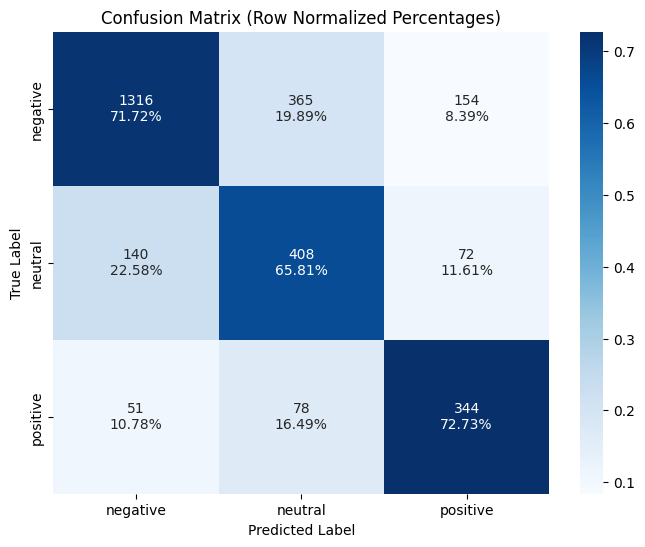

****************************************************************************************************
KERNEL : rbf
              precision    recall  f1-score   support

    negative       0.87      0.74      0.80      1835
     neutral       0.52      0.66      0.58       620
    positive       0.60      0.72      0.66       473

    accuracy                           0.72      2928
   macro avg       0.66      0.71      0.68      2928
weighted avg       0.75      0.72      0.73      2928





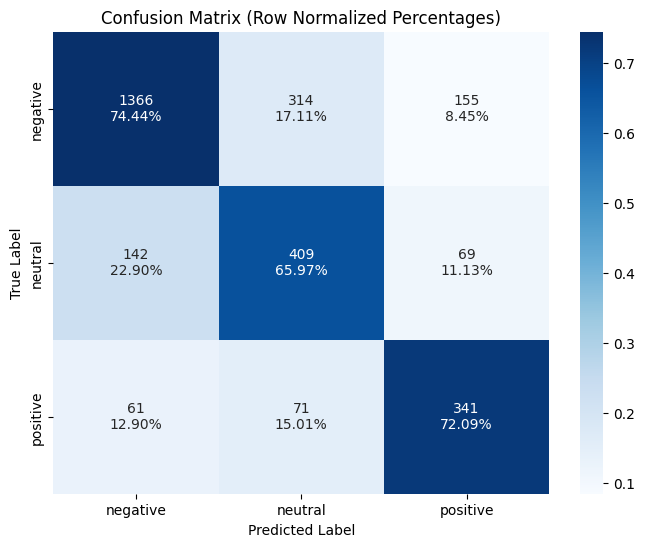

****************************************************************************************************
KERNEL : sigmoid
              precision    recall  f1-score   support

    negative       0.68      0.89      0.77      1835
     neutral       0.39      0.20      0.26       620
    positive       0.65      0.31      0.42       473

    accuracy                           0.65      2928
   macro avg       0.58      0.47      0.49      2928
weighted avg       0.62      0.65      0.61      2928





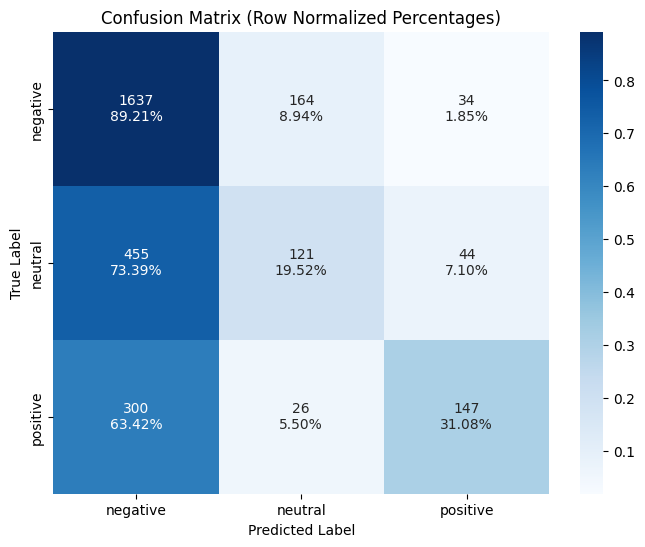

****************************************************************************************************


In [ ]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
  svm = SVC(class_weight='balanced', kernel=kernel, random_state=42)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_test)
  print(f"KERNEL : {kernel}\n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}\n\n")
  temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
  results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
  models.append(f'SVM - {kernel} kernel')
  get_confusion_matrix(y_test, y_pred, f"svm_{kernel}", label_encoder, DOWNSAMPLE)
  print("*"*100)

## Gaussian Naive Bayes

Gaussian Naive Bayes : 
              precision    recall  f1-score   support

    negative       0.77      0.91      0.84      1835
     neutral       0.57      0.39      0.46       620
    positive       0.74      0.53      0.62       473

    accuracy                           0.74      2928
   macro avg       0.69      0.61      0.64      2928
weighted avg       0.72      0.74      0.72      2928



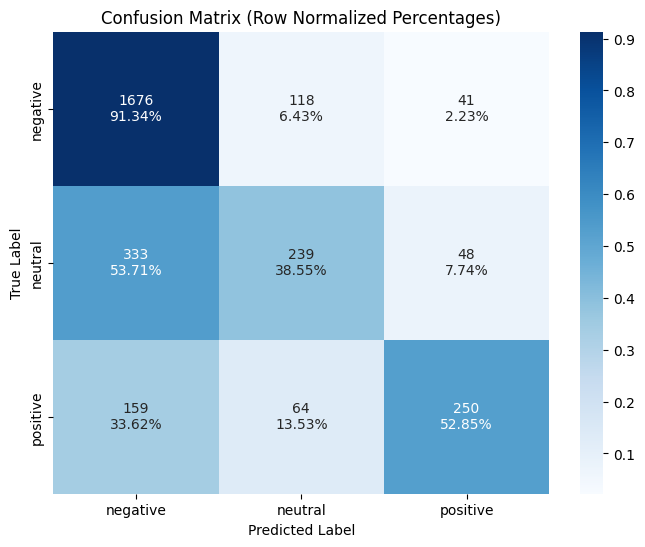

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Gaussian Naive Bayes : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")
get_confusion_matrix(y_test, y_pred, "gaussian_naive_bayes", label_encoder, DOWNSAMPLE)
temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
models.append(f'Gaussian Naive Bayes')

## MLP Classifier

MLP Classifier : 
              precision    recall  f1-score   support

    negative       0.77      0.92      0.84      1835
     neutral       0.59      0.38      0.47       620
    positive       0.74      0.54      0.62       473

    accuracy                           0.74      2928
   macro avg       0.70      0.61      0.64      2928
weighted avg       0.73      0.74      0.72      2928



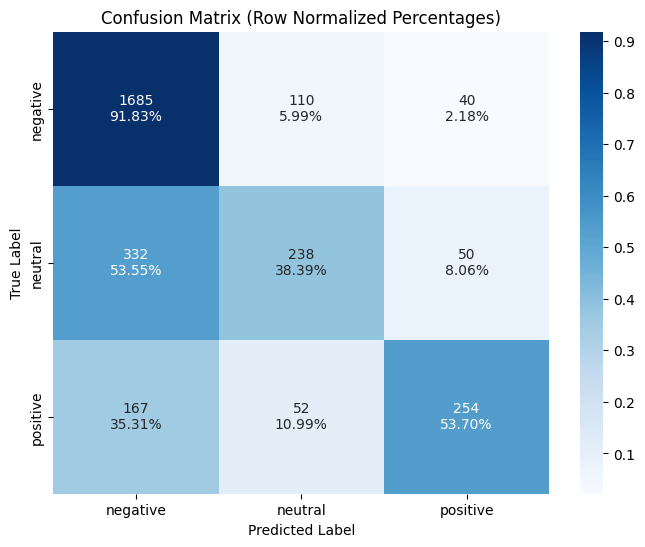

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(), max_iter=500, random_state=42) # just a shallow MLP, input -> output
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"MLP Classifier : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")
get_confusion_matrix(y_test, y_pred, "mlp_classifier", label_encoder, DOWNSAMPLE)
temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
models.append(f'MLP Classifier')

## Decision Tree

Decision Tree : 
              precision    recall  f1-score   support

    negative       0.75      0.72      0.74      1835
     neutral       0.38      0.41      0.40       620
    positive       0.40      0.40      0.40       473

    accuracy                           0.61      2928
   macro avg       0.51      0.51      0.51      2928
weighted avg       0.61      0.61      0.61      2928



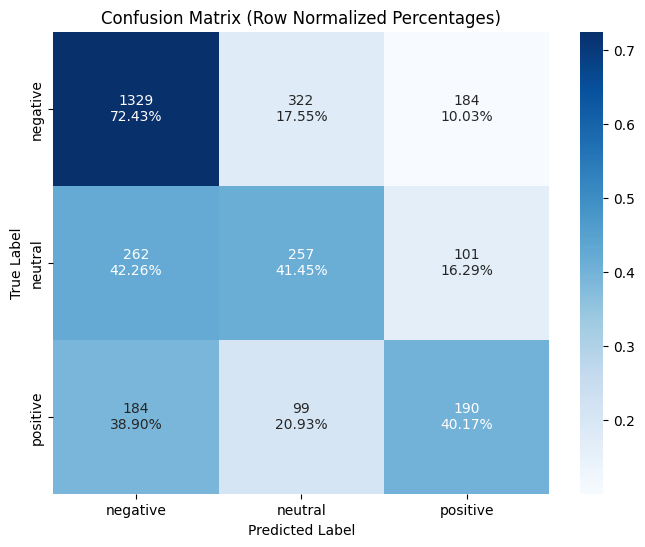

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Decision Tree : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")
get_confusion_matrix(y_test, y_pred, "decision_tree", label_encoder, DOWNSAMPLE)
temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
models.append(f'Decision Tree')

## Shallow Random Forest

Random Forest Classifier : 
              precision    recall  f1-score   support

    negative       0.67      0.99      0.80      1835
     neutral       0.72      0.14      0.23       620
    positive       0.78      0.18      0.29       473

    accuracy                           0.68      2928
   macro avg       0.72      0.44      0.44      2928
weighted avg       0.70      0.68      0.60      2928



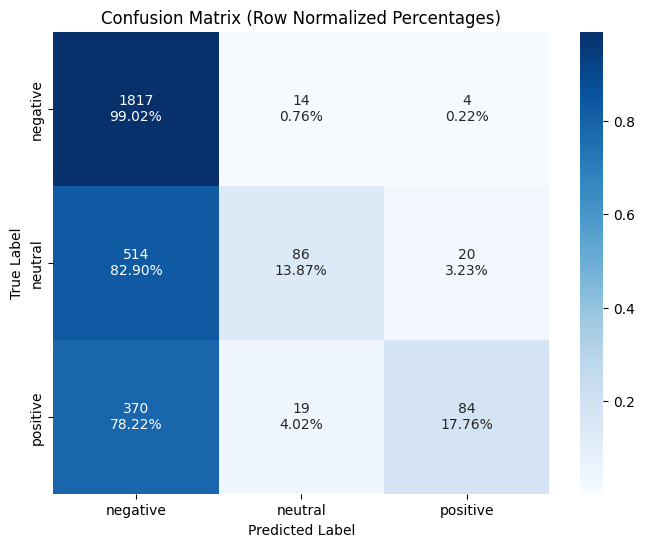

In [ ]:
clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Random Forest Classifier : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")
get_confusion_matrix(y_test, y_pred, "random_forest", label_encoder, DOWNSAMPLE)
temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
models.append(f'(Shallow) Random Forest')

## Ridge Classifier

Ridge Classifier : 
              precision    recall  f1-score   support

    negative       0.73      0.96      0.83      1835
     neutral       0.65      0.28      0.39       620
    positive       0.80      0.43      0.56       473

    accuracy                           0.73      2928
   macro avg       0.73      0.56      0.59      2928
weighted avg       0.73      0.73      0.69      2928



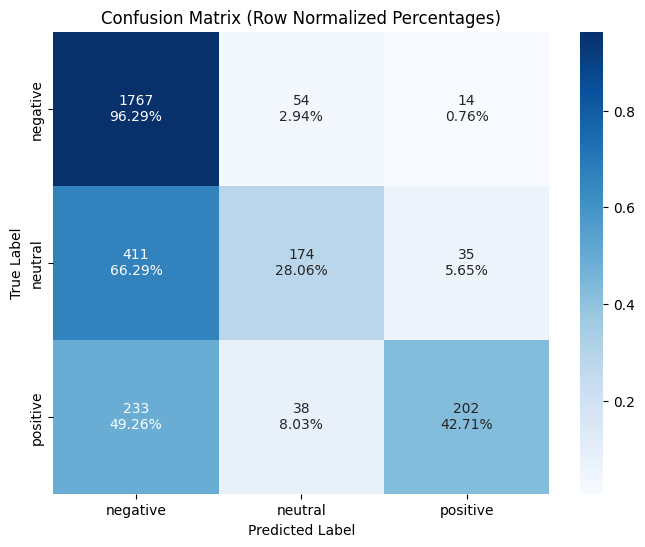

In [ ]:
clf = RidgeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Ridge Classifier : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")
get_confusion_matrix(y_test, y_pred, "ridge_classifier", label_encoder, DOWNSAMPLE)
temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
models.append(f'Ridge Classifier')

## KNN Classifier

KNN Classifier : 
              precision    recall  f1-score   support

    negative       0.70      0.96      0.81      1835
     neutral       0.61      0.23      0.33       620
    positive       0.73      0.31      0.43       473

    accuracy                           0.70      2928
   macro avg       0.68      0.50      0.53      2928
weighted avg       0.69      0.70      0.65      2928



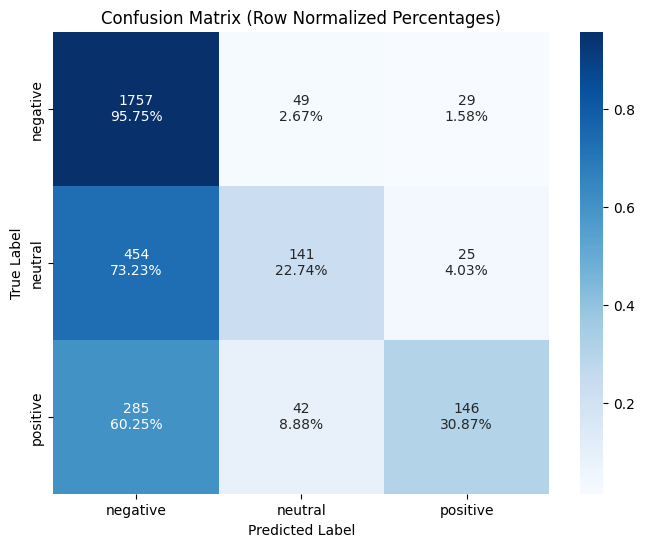

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"KNN Classifier : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")
get_confusion_matrix(y_test, y_pred, "knn_classifier", label_encoder, DOWNSAMPLE)
temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
models.append(f'KNN Classifier')

## Passive Aggressive Classifier

Passive Aggressive Classifier : 
              precision    recall  f1-score   support

    negative       0.79      0.86      0.82      1835
     neutral       0.46      0.50      0.48       620
    positive       0.77      0.42      0.54       473

    accuracy                           0.71      2928
   macro avg       0.67      0.59      0.61      2928
weighted avg       0.72      0.71      0.71      2928



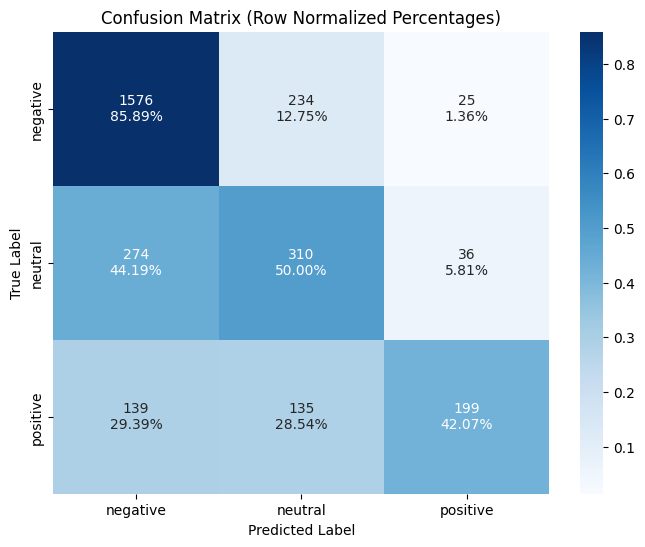

In [ ]:
clf = PassiveAggressiveClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Passive Aggressive Classifier : \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")
get_confusion_matrix(y_test, y_pred, "passive_aggressive_classifier", label_encoder, DOWNSAMPLE)
temp = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
results.append([temp['negative']['f1-score'], temp['neutral']['f1-score'], temp['positive']['f1-score'], temp['weighted avg']['f1-score']])
models.append(f'Passive Aggressive Classifier')

## SVM RBF (PRINTING misclassifications)

In [ ]:
svm = SVC(class_weight='balanced', kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [ ]:
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

for text, true_label, predicted_label in zip(test_df['text'], y_test_original, y_pred_original):
  if true_label != predicted_label:
    print(f"True : {true_label}, Predicted : {predicted_label}, Text : {text}")

True : positive, Predicted : negative, Text : @JetBlue would you say a delay is more likely? Thanks so much.
True : negative, Predicted : positive, Text : @united disappointed that u didnt honor my $100 credit given to me for ur mistakes. Taking my business elsewhere  ✌️out.
True : neutral, Predicted : negative, Text : @united This link in your tweet goes to someone's internal email -&gt; http://t.co/ZksX79itdN...... Probably one of your 3rd party IT contracts
True : negative, Predicted : neutral, Text : @SouthwestAir When will the flight resume? I don's see it in the open schedule. :/
True : negative, Predicted : neutral, Text : @AmericanAir why would I pay $200 to reactivate my points that are only useful for certain flights that aren't even worth $200?
True : negative, Predicted : positive, Text : @united too long for 140 characters
True : positive, Predicted : negative, Text : @USAirways Well I did miss it. But gate agents had rebooked boarding pass waiting when I landed. Time for 

I conducted a qualitative analysis of SVM RBF's misclassifications. The results are interesting, and highlight a few limitations. **Please keep in mind this isn't a detailed analysis, I looked at around 10-20 examples and have made these conclusions.**

- The model relies on keywords like "thanks", "please", without understanding the underlying tone / context. A lot of the tweets express sarcasm / frustration without explicit negative words and in a non aggressive manner, and the  model misclassifies them. For example :
@AmericanAir pleaseeee find my suitcase. I want deoderant and a clean shirt for work tomorrow :( (predicted=positive, true=negative).

- Something weird, but a lot of tweets that contain words like 'flight', 'delay', 'boarding' are classified as negative (I assume due to a lot of tweets in the training set containing words like these being labeled negative)


- There are some tweets where it is obvious what the sentiment is but the model misclassifies them.
    - True: negative, Predicted: positive, Text: @JetBlue Usually I have such a great experience with you guys? Very, very unhappy with you right now.
    - True: negative, Predicted: positive, Text: @united you always surprise me with the awfulness of your airline. You guys suck. #worst


- However, I don't want to blame the model entirely, these are some examples I also found hard to classify.
    - True: neutral, Predicted: negative, Text: @AmericanAir travel week, delays, Cancelled Flightlations, "if you want to learn more about the merger press 1", delay my connector in Chicago #deice
    - True: negative, Predicted: neutral, Text: @AmericanAir flight was 2488 out of EWR STOP AT DALLAS THEN TO LA. I need to be in la tonight! (I thought it was borderline neutral)
    - True: negative, Predicted: neutral, Text: @JetBlue nope. None to be found (No context at all, I am assuming it is a reply to a tweet, difficult to interpret on its own.)
    - True: positive, Predicted: neutral, Text: @JetBlue things happen it's ok just wish I was on the beach and not in the airport (Sentiment is unclear, or rather feels more negative.)
    - True: neutral, Predicted: positive, Text: @JetBlue I sure hope you guys get me to DC to speak tomorrow! & @JohnNosta & @United: I'm winning here with @JetBlue (Presence of "I'm winning here" likely influenced the positive prediction.)

TLDR : According to me, the model relies on superficial things like keywords to classify sentiment, and struggles with detecting tones, especially sarcasm and frustration. Notable bias towards classifying tweets containing words like flight, delay, boarding, etc. as negative.

## Final Results (table of all classifier results)

In [ ]:
headers = ["Method", "F1 (Negative)", "F1 (Neutral)", "F1 (Positive)", "Weighted F1"]
table_data = []

for model, result in zip(models, results):
    row = [model] + result
    table_data.append(row)

print(tabulate(table_data, headers=headers, tablefmt="github", floatfmt=".2f"))

| Method                        |   F1 (Negative) |   F1 (Neutral) |   F1 (Positive) |   Weighted F1 |
|-------------------------------|-----------------|----------------|-----------------|---------------|
| Logistic Regression           |            0.84 |           0.46 |            0.62 |          0.72 |
| SVM - linear kernel           |            0.78 |           0.52 |            0.65 |          0.70 |
| SVM - poly kernel             |            0.79 |           0.55 |            0.66 |          0.72 |
| SVM - rbf kernel              |            0.80 |           0.58 |            0.66 |          0.73 |
| SVM - sigmoid kernel          |            0.77 |           0.26 |            0.42 |          0.61 |
| Gaussian Naive Bayes          |            0.84 |           0.46 |            0.62 |          0.72 |
| MLP Classifier                |            0.84 |           0.47 |            0.62 |          0.72 |
| Decision Tree                 |            0.74 |           0.40 |     

The SVM with RBF kernel achieved the highest overall performance (Weighted F1: 0.73), slightly outperforming other models. The top-performing classifiers were closely matched, indicating robust baselines for sentiment classification: SVM, RBF kernel (0.73); Logistic Regression (0.72); MLP Classifier (0.72); SVM, Poly kernel (0.72); Passive Aggressive (0.71).

Neutral tweets were the most difficult to classify, with F1 scores significantly lower than positive/negative classes. SVM with a RBF kernel performed best (F1: 0.58), but all models struggled on this class,maybe due to ambiguous langauge.

However, SVM with a RBF kernel delivered the most balanced performance across all three sentiments, making it the most reliable choice. Logistic Regression and MLP also performed well, particularly for the Positive and Negative Classes.

# SVM RBF Hyperparameter Tuning

I selected SVM with RBF to be my final model based on the results presented in the table above. Ofcourse, to do so in real life, there would need to be some kind of statistical test done, to see whether the predictions between the classifiers are statistically significant (Something like McNemar's test for binary classification https://machinelearningmastery.com/mcnemars-test-for-machine-learning/ ). Ideally, my flow would be to find out which models' outputs are **not** statistically significant, and then do 5 fold Cross Validation and Hyperparameter Tuning on those models, which will give me THE best model, backed by experiments. However, for the purpose of the case study, this is what I have chosen to go with.

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
}

svc = SVC(kernel='rbf', class_weight='balanced', random_state=42)

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svc = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 1}


In [ ]:
y_pred = best_svc.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      1835
     neutral       0.56      0.60      0.58       620
    positive       0.73      0.51      0.60       473

    accuracy                           0.76      2928
   macro avg       0.71      0.66      0.68      2928
weighted avg       0.76      0.76      0.75      2928



Lets see how it compares to the performance with default parameters

```
              precision    recall  f1-score   support

    negative       0.87      0.74      0.80      1835
     neutral       0.52      0.66      0.58       620
    positive       0.60      0.72      0.66       473

    accuracy                           0.72      2928
   macro avg       0.66      0.71      0.68      2928
weighted avg       0.75      0.72      0.73      2928
```

Negative class becomes better, but the recall for the positive class goes down way more. The model now makes fewer but more confident positive predictions. I would say that the we should still keep the model with the default parameters.

# Future Steps

- I think the main limitation right now is using static glove embeddings, which fail to capture contextual meaning, which is VERY VERY important in a task like sentiment analysis. Switching to contextual embeddings (using CPU friendly libraries like SentenceBERT) could better handle nuances and improve performance. I also think that static embeddings is the reason why emoji to text fails.
- Currently, the final model is selected based on weighted F1, but proper statistical significance tests, cross validation, and hyperparameter tuning should be implemented for more reliable comparisons.
- Class weights might help.
- If not the constraint of being CPU friendly, I would go for slightly advanced models, for example BERTForSequenceClassification, or use Adapters (makes it less resource intensive).
- Tweets are written very informally, containing a lot of slang, and wrong spellings (for example, 'you' is spelt as 'u'). Future work should handle this.